In [64]:
import networkx as nx
import pandas as pd
import numpy as np
import nxviz as nv
import matplotlib.pyplot as plt

from analysis_utils import *
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
disbiome_md_path = '../data/MAGNN_data/disbiome_taxid_mondo.dat'
disbiome_md_df = load_data(disbiome_md_path, colname1="microbe", colname2="disease")
gmmad2_md_path = '../data/MAGNN_data/gmmad2_taxid_mondo.dat'
gmmad2_md_df = load_data(gmmad2_md_path, colname1="microbe", colname2="disease")
md_combined_df = merge_df([disbiome_md_df, gmmad2_md_df])

gmmad2_mm_path = '../data/MAGNN_data/gmmad2_taxid_met.dat'
gmmad2_mm_df = load_data(gmmad2_mm_path, colname1="microbe", colname2="metabolite")
hmdb_mm_path = '../data/MAGNN_data/hmdb_taxid_met.dat'
hmdb_mm_df = load_data(hmdb_mm_path, colname1="microbe", colname2="metabolite")
mm_combined_df = merge_df([gmmad2_mm_df, hmdb_mm_df])

metd_path = "../data/MAGNN_data/hmdb_met_disease.dat"
metd_df = load_data(metd_path,colname1="metabolite", colname2="disease")
metd_df = merge_df([metd_df])

Total count of edges: 
microbe    505325
disease    505325
dtype: int64
Total count of edges: 
microbe       599176
metabolite    599176
dtype: int64
Total count of edges: 
metabolite    27546
disease       27546
dtype: int64


In [3]:
# create networkx graph with node type as part of node metadata dict 
G = nx.Graph()

for _, row in md_combined_df.iterrows():
    G.add_edge(row["microbe"], row["disease"])
for n in G.nodes():
    if n not in G.nodes[n]:
        G.nodes[n]['type'] = 'microbe' if n in md_combined_df['microbe'].values else 'disease'

for _, row in mm_combined_df.iterrows():
    G.add_edge(row['microbe'], row['metabolite'])
for n in G.nodes():
    if "type" not in G.nodes[n]:
        G.nodes[n]['type'] = 'microbe' if n in mm_combined_df['microbe'].values else 'metabolite'

for _, row in metd_df.iterrows():
    G.add_edge(row['metabolite'], row['disease'])
for n in G.nodes():
    if "type" not in G.nodes[n]:
        G.nodes[n]['type'] = 'metabolite' if n in metd_df['metabolite'].values else 'disease'

In [4]:
density = nx.density(G)
components = nx.number_connected_components(G)
degree_correlation = nx.degree_assortativity_coefficient(G)

print(f"Graph Density: {density*100}% of the possible connections between nodes")
print(f"Number of distinct sub-networks within overall network: {components}")
print(f"Degree Correlation where high-degree nodes are connected to peripheral nodes: {degree_correlation}")

Graph Density: 0.20888576318715205% of the possible connections between nodes
Number of distinct sub-networks within overall network: 27
Degree Correlation where high-degree nodes are connected to peripheral nodes: -0.38043422383946


In [5]:
# calculate degree centrality
degree_centrality = nx.degree_centrality(G)
d_cen_nodes_df = pd.DataFrame(list(degree_centrality.items()), columns=['Node', 'Degree Centrality'])
d_cen_nodes_df.set_index('Node', inplace=True)

In [6]:
# add degree centrality to graph node attribute
for n in G.nodes():
    G.nodes[n]["centrality"] = degree_centrality[n]

In [7]:
# show the top 10 highest node degree centrality
top_degree = d_cen_nodes_df.nlargest(10, 'Degree Centrality')
top_degree

,Degree Centrality
Node,
MONDO:0010543,0.608013
MONDO:0005101,0.198348
MONDO:0005265,0.195948
MONDO:0021085,0.194217
MONDO:0005148,0.190086
MONDO:0005052,0.189843
MONDO:0005260,0.189478
MONDO:0005335,0.189083
MONDO:0005011,0.188506


In [8]:
print(f"Total number of nodes: {len(G.nodes())}")
print(f"Total number of edges: {len(G.edges())}")
one_nbr = nodes_with_m_nbrs(G, 1)
print(f"percent of 1 neighbor node: {len(one_nbr)/len(G.nodes())*100}%")
deg_seq = [d for n, d in G.degree()]
print(f"Average degree: {np.mean(deg_seq)}")

Total number of nodes: 32923
Total number of edges: 1132047
Number of nodes with 1 neighbor(s): 21884
percent of 1 neighbor node: 66.47024876226347%
Average degree: 68.76937095647419


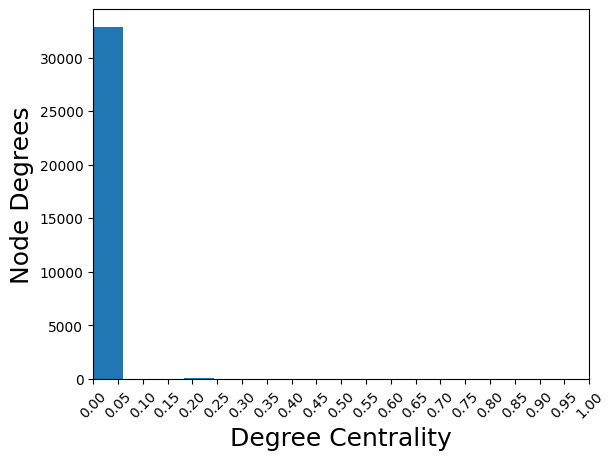

In [9]:
# visualize degree centrality distribution
plt.hist(list(degree_centrality.values()))
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.05, 0.05), rotation=45)
plt.xlabel("Degree Centrality", fontsize=18)
plt.ylabel("Node Degrees", fontsize=18)
plt.show()

In [10]:
# calculate the number of neighbors for each node
degrees = [len(list(G.neighbors(node))) for node in G.nodes()]        

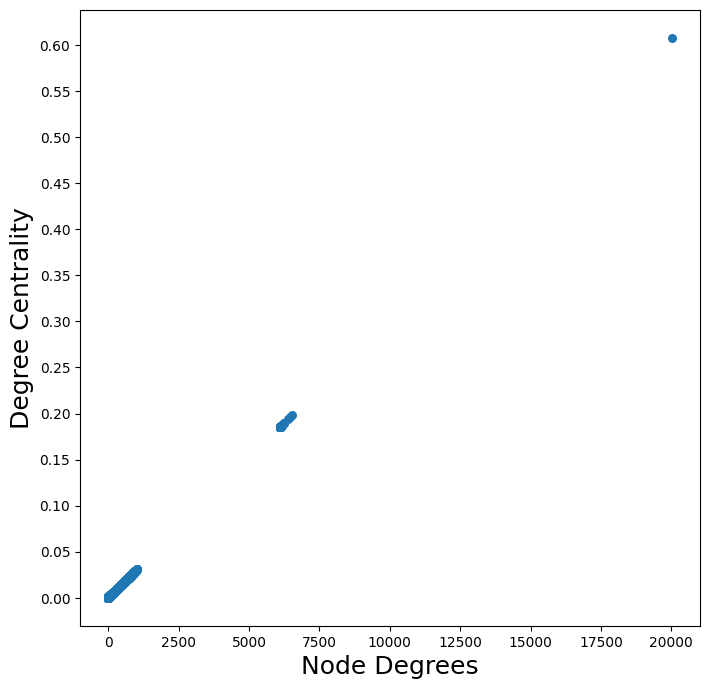

In [11]:
# scatter plot with x as number of node neighbors and y as degree centrality (percent of the total number of connections a node has)
plt.figure(figsize=(8, 8))
plt.scatter(x=degrees, y=list(degree_centrality.values()), s=30)
plt.yticks(np.arange(0, 0.65, 0.05))
plt.xlabel("Node Degrees", fontsize=18)
plt.ylabel("Degree Centrality", fontsize=18)
plt.show()

In [10]:
# calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

KeyboardInterrupt: 

In [36]:
bet_cen_nodes_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Node', 'Betweenness Centrality'])
bet_cen_nodes_df.set_index('Node', inplace=True)

In [40]:
bet_cen_nodes_df.get('Betweenness Centrality').nlargest(20)

Node
MONDO:0010543               0.843961
PUBCHEM.COMPOUND:1060       0.471468
MONDO:0005052               0.127275
MONDO:0005147               0.117135
MONDO:0005575               0.038072
MONDO:0013995               0.035093
MONDO:0005101               0.023846
MONDO:0005265               0.013591
MONDO:0021085               0.010704
MONDO:0019182               0.009069
MONDO:0005260               0.008269
MONDO:0005148               0.007991
MONDO:0012451               0.007285
NCBITaxon:562               0.005761
MONDO:0005090               0.004899
MONDO:0008383               0.004599
MONDO:0005335               0.004481
MONDO:0009061               0.004334
MONDO:0005011               0.003753
PUBCHEM.COMPOUND:1551553    0.003317
Name: Betweenness Centrality, dtype: float64

In [88]:
plt.figure()
plt.scatter(x=list(betweenness_centrality.values()), y=list(degree_centrality.values()))
plt.xlabel("Betweenness Centrality", fontsize=18)
plt.ylabel("Degree Centrality", fontsize=18)
plt.show()

NameError: name 'betweenness_centrality' is not defined

<Figure size 640x480 with 0 Axes>

In [12]:
# find the maximal cliques in graph with size 3
mc_3 = maximal_cliques(G, 3)

Number of maximal cliques with size 3: 11121


In [90]:
# look at the subgraph of "MONDO:0005052"
t10_nbrs = set(G.neighbors("MONDO:0005052"))
t10_nbrs = t10_nbrs.union({"MONDO:0005052"})
t10_sub = G.subgraph(t10_nbrs)

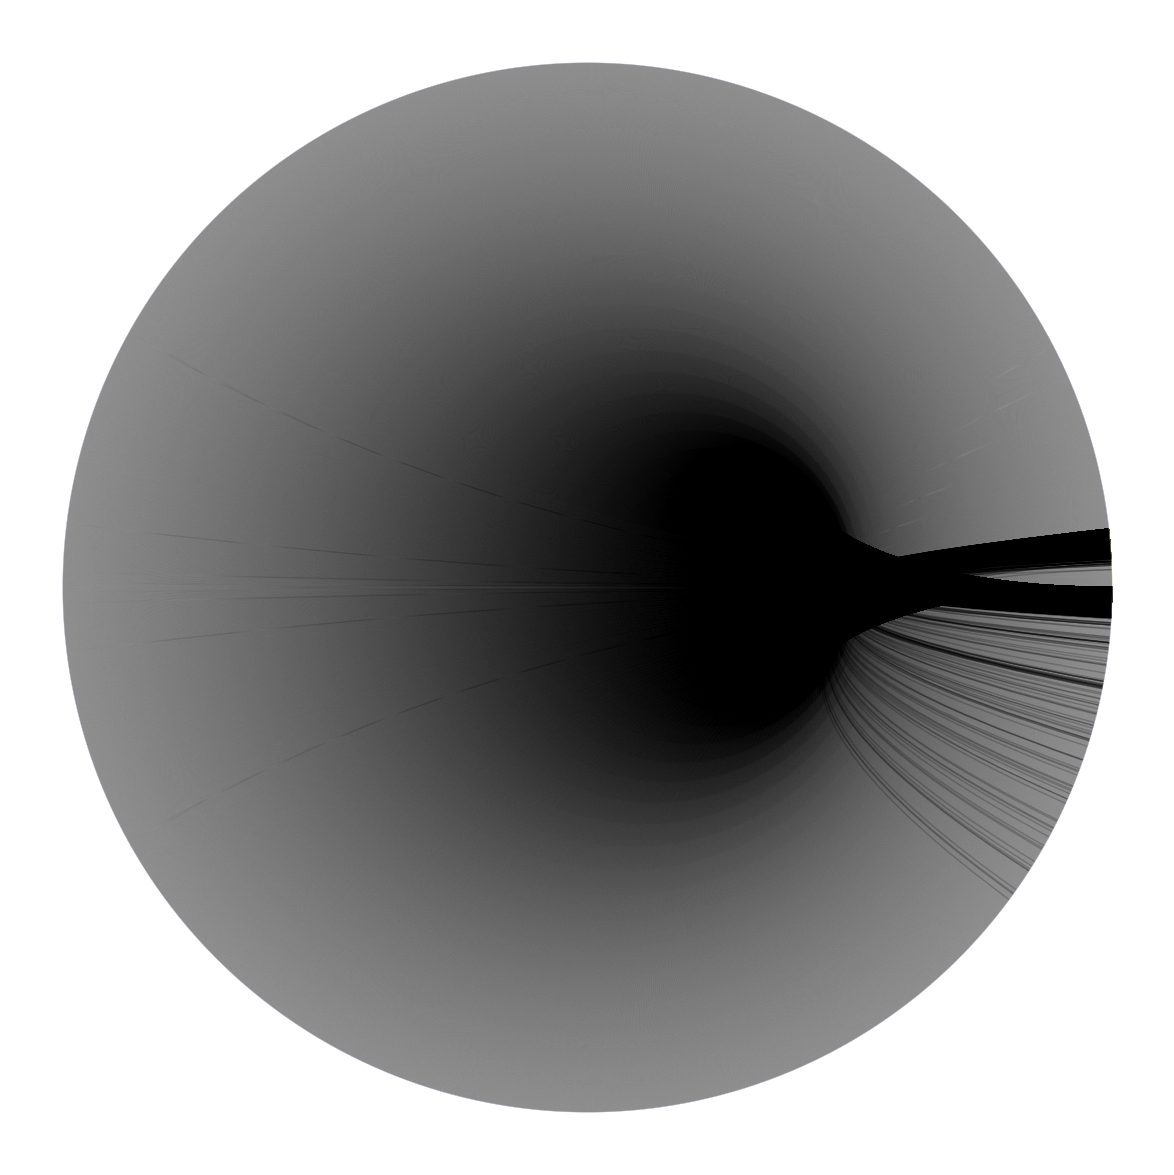

In [92]:
# draw the subgraph of "MONDO:0005052"
plt.figure(figsize=(15, 15))
nv.circos(t10_sub, node_color_by="type", group_by="type", sort_by="centrality", node_enc_kwargs={'radius': 1})
plt.show()

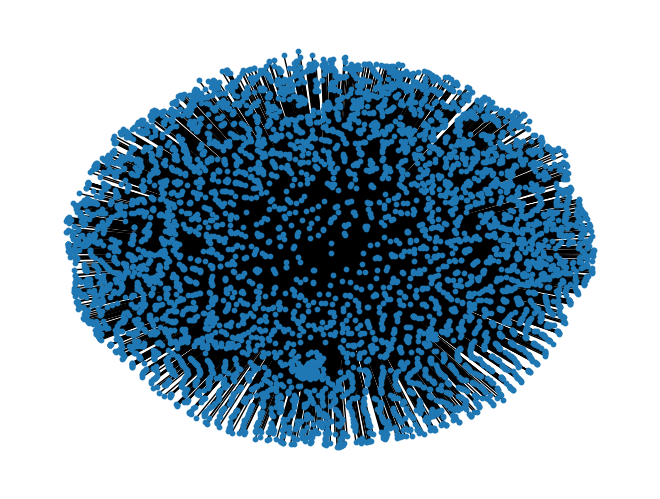

In [14]:
# draw the subgraph of "MONDO:0005052"
nx.draw(t10_sub, node_size=10)
plt.show()

In [15]:
print(f"Total number of nodes of 'MONDO:0005052' subgraph: {len(t10_sub.nodes())}")

Total number of nodes of 'MONDO:0005052' subgraph: 6251


In [16]:
print(f"Total number of edges of 'MONDO:0005052' subgraph: {len(t10_sub.edges())}")

Total number of edges of 'MONDO:0005052' subgraph: 8573


In [17]:
# find connected networks
list(nx.connected_components(G))

[{'PUBCHEM.COMPOUND:131788310',
  'PUBCHEM.COMPOUND:443161',
  'HMDB:HMDB0076718',
  'PUBCHEM.COMPOUND:131786521',
  'PUBCHEM.COMPOUND:131796426',
  'PUBCHEM.COMPOUND:131796965',
  'PUBCHEM.COMPOUND:151187',
  'HMDB:HMDB0082898',
  'HMDB:HMDB0084031',
  'MONDO:0012393',
  'HMDB:HMDB0092755',
  'PUBCHEM.COMPOUND:131784135',
  'PUBCHEM.COMPOUND:131787067',
  'NCBITaxon:350811',
  'NCBITaxon:1048424',
  'PUBCHEM.COMPOUND:5359268',
  'NCBITaxon:1827145',
  'PUBCHEM.COMPOUND:131787052',
  'HMDB:HMDB0076916',
  'HMDB:HMDB0083106',
  'HMDB:HMDB0089257',
  'NCBITaxon:213810',
  'PUBCHEM.COMPOUND:131788412',
  'NCBITaxon:405946',
  'MONDO:5406',
  'NCBITaxon:512566',
  'PUBCHEM.COMPOUND:131789360',
  'PUBCHEM.COMPOUND:440279',
  'HMDB:HMDB0091026',
  'PUBCHEM.COMPOUND:131782868',
  'HMDB:HMDB0075736',
  'NCBITaxon:115744',
  'HMDB:HMDB0089144',
  'HMDB:HMDB0090628',
  'PUBCHEM.COMPOUND:1015',
  'NCBITaxon:1386909',
  'PUBCHEM.COMPOUND:131792865',
  'HMDB:HMDB0081855',
  'PUBCHEM.COMPOUND:534817

In [19]:
# calculate the number of nodes in each connected networks
component_sizes = [len(g) for g in nx.connected_components(G)]
component_sizes = sorted(component_sizes, reverse=True)
print(component_sizes)
print(f"Number of distinct connected networks: {len(component_sizes)}")

[32860, 5, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Number of distinct connected networks: 27


In [18]:
sec_largest_ccs = sorted(nx.connected_components(G), key=lambda x: len(x))[-2]
sec_lccs = G.subgraph(sec_largest_ccs)

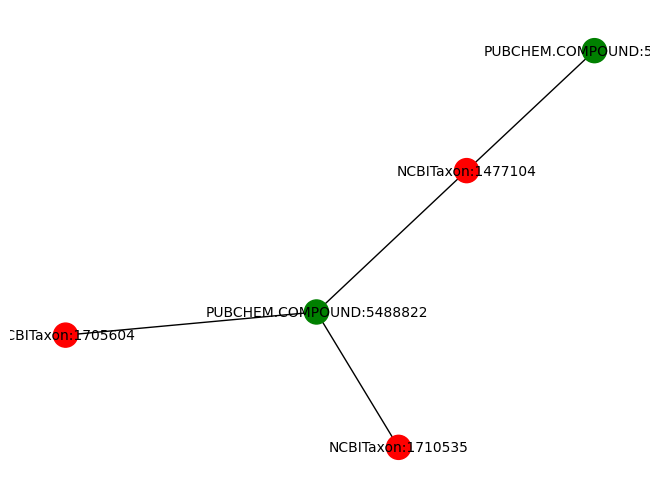

In [20]:
node_colors = []
for n in sec_lccs.nodes():
    if G.nodes[n]['type'] == 'microbe':
        node_colors.append('red')
    elif G.nodes[n]['type'] == 'disease':
        node_colors.append('blue')
    elif G.nodes[n]['type'] == 'metabolite':
        node_colors.append('green')
nx.draw(sec_lccs, with_labels=True, font_size=10, node_color=node_colors)
plt.show()

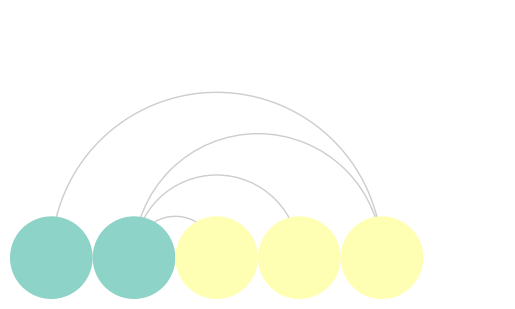

In [21]:
nv.arc(sec_lccs, node_color_by="type", group_by="type", sort_by="centrality")
plt.show()

In [24]:
# find the largest connected network as G.subgraph
largest_ccs = sorted((G.subgraph(c) for c in nx.connected_components(G)), key=lambda x: len(x))[-1]
print(f"Number of nodes in the largest connected network: {len(largest_ccs.nodes())}")
print(f"Number of edges in the largest connected network: {len(largest_ccs.edges())}")

Number of nodes in the largest connected network: 32860
Number of edges in the largest connected network: 1132010


In [87]:
# get top node degree centrality in larges connected network
t2_ccs = []
for n in list(largest_ccs)[:3]:
    t2_ccs.append(n)
    print(f"Node(s): {n}")
    for nbr in G.neighbors(n):
        t2_ccs.append(nbr)
t2_ccs_draw = G.subgraph(t2_ccs)
type_ct = []
ct = 0
for n in t2_ccs_draw.nodes():
    type_ct.append(t2_ccs_draw.nodes[n]['type'])
print(f"Node neighbor count: {Counter(type_ct)}")
print(f"Total number of nodes: {len(list(t2_ccs_draw.nodes()))}")
print(f"Total number of edges: {len(list(t2_ccs_draw.edges()))}")

Node(s): NCBITaxon:165179
Node(s): MONDO:0019100
Node(s): NCBITaxon:1686
Node neighbor count: Counter({'disease': 105, 'microbe': 9, 'metabolite': 2})
Total number of nodes: 116
Total number of edges: 617


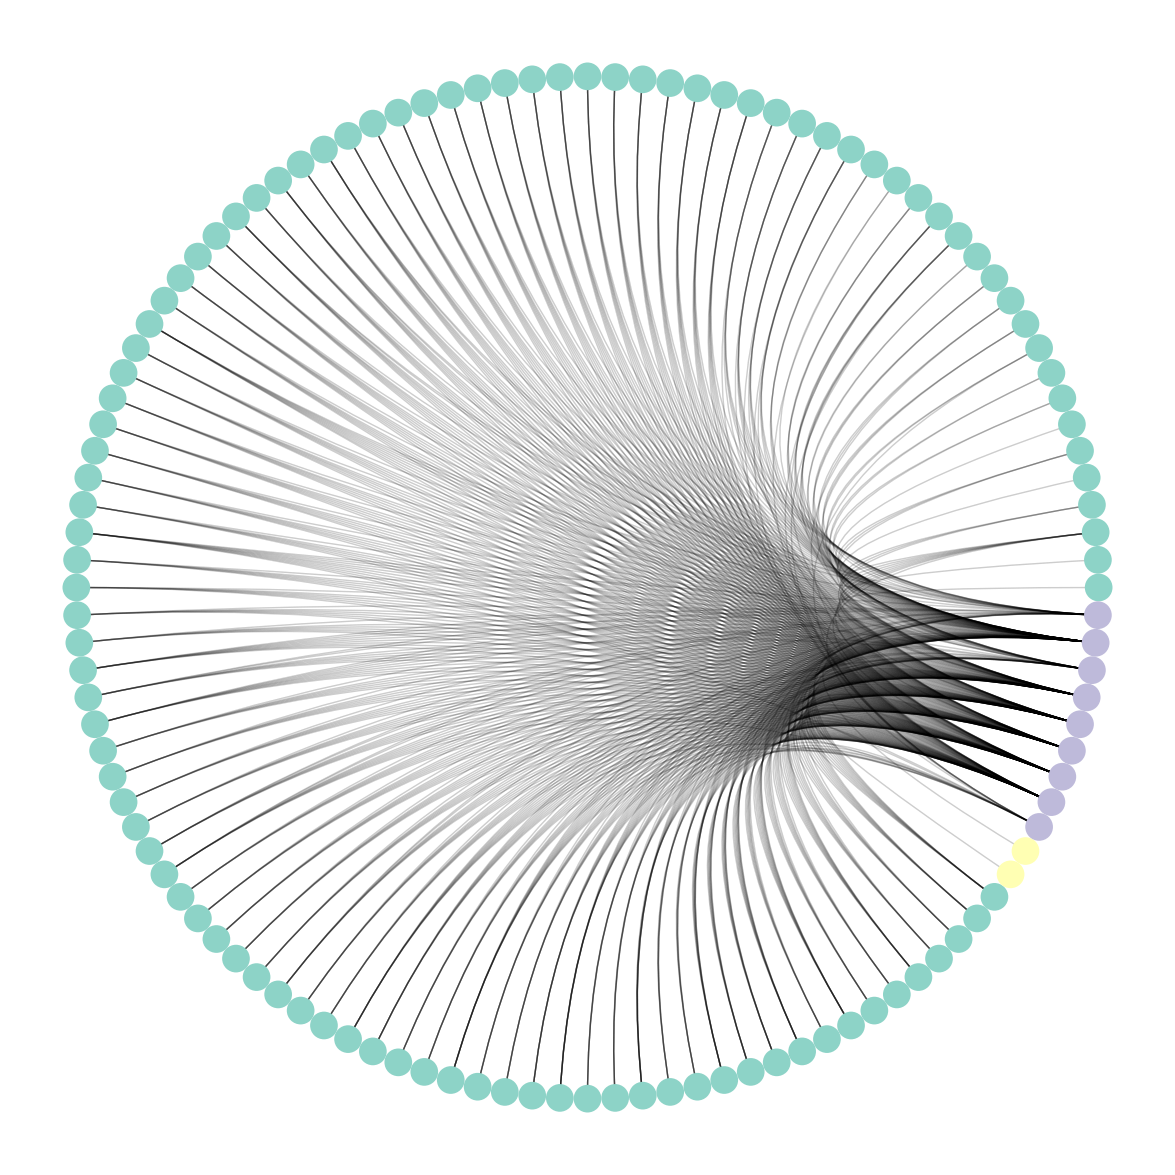

In [83]:
plt.figure(figsize=(15, 15))
nv.circos(t2_ccs_draw, node_color_by="type", group_by="type", sort_by="centrality", node_enc_kwargs={'radius': 1})
plt.show()

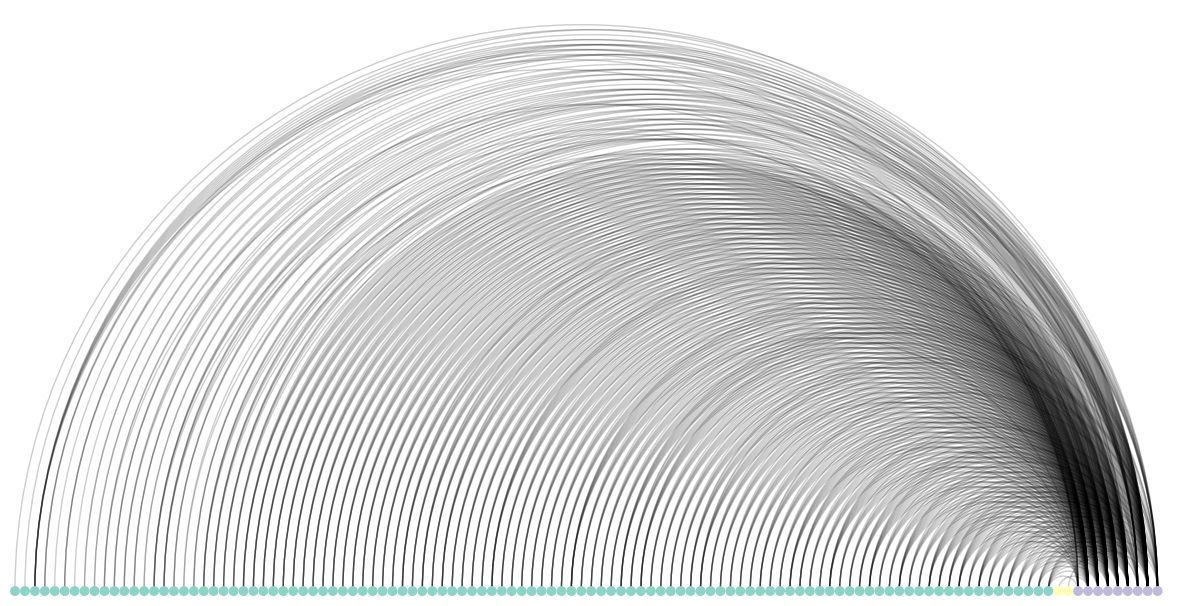

In [88]:
plt.figure(figsize=(15, 15))
nv.arc(t2_ccs_draw, node_color_by="type", group_by="type", sort_by="centrality")
plt.show()